# Title project: Dampak Penggunaan Jumlah Aplikasi Harian terhadap Kinerja Akademik Siswa Kelas 12

## Project overview
Proyek ini bertujuan untuk menganalisis hubungan liniar antara jumlah aplikasi yang digunakan setiap hari `(Apps_Used_Daily)`, dengan kinerja akademik `(Academic_Performance)` di kalangan siswa kelas 12. proyek ini mengadopsi pendekatan dua tahap antara lain:

1. Klasifikasi Berbasis Kode: Siswa dikelompokkan ke dalam empat profil pengguna yang berbeda (Minimal, Moderate, Heavy, Power User) berdasarkan distribusi kuartil dari data penggunaan aplikasi harian mereka. Pendekatan ini memastikan klasifikasi yang objektif, cepat, dan hemat biaya.

2. Prediksi Berbasis AI: Hasil analisis dari pengelompokan tersebut kemudian disajikan sebagai konteks kepada Large Language Model (LLM) IBM Granite. AI digunakan untuk melakukan prediksi dua arah (memprediksi skor dari profil, dan sebaliknya) lengkap dengan penalaran logis berdasarkan data yang disajikan.

> Tujuan akhirnya adalah untuk mengungkap hubungan linear sebesar apa, serta mendemonstrasikan penggunaan AI ibm dalam analisis data.

## Raw Dataset Link
Dataset yang digunakan dalam proyek ini adalah "Teen Phone Addiction" yang tersedia secara publik di Kaggle. https://www.kaggle.com/datasets/sumedh1507/teen-phone-addiction

## Insight & Findings
Adanya korelasi negatif lemah antara jumlah aplikasi yang digunakan vs performa akademik kurang lebih sebesar -0.026136 atau sekitar 2,6%, yang artinya jumlah aplikasi tidak terlalu berpengaruh terhadap nilai akademik yang dicapai. Namun hal yang dapat kita pelajari disini adalah karena korelasinya negatif maka semakin sedikit aplikasi yang kita gunakan setiap harinya akan memiliki hubungan terbalik terhadap nilai akademik yang didapatkan yaitu lebih besar dan sebaliknya.

## AI Support Explanation
Dalam proyek ini, model ibm-granite/granite-3.0-8b-instruct dari IBM dimanfaatkan untuk penalaran prediktif berbasis dataset.

AI berperan sebagai seorang analis data ahli. Setelah analisis dan pengelompokan awal dilakukan dengan kode, sebuah ringkasan temuan (tabel kinerja akademik per profil pengguna) diberikan kepada model sebagai "base knowledge". Berdasarkan konteks ini, AI ditugaskan untuk:

1. Memprediksi rentang kinerja akademik seorang siswa jika profil penggunaannya diketahui.
2. Memprediksi profil pengguna yang paling mungkin jika skor akademiknya diketahui.
3. Memberikan alasan (reasoning) yang logis untuk setiap prediksi, yang didasarkan sepenuhnya pada data ringkasan yang diberikan.

Mengapa Pendekatan Ini Dipilih: Karena pendekatan ini memanfaatkan kekuatan dari LLM untuk memahami, menalar, dan mengartikulasikan hubungan dalam bahasa alami, yang menunjukkan AI dapat berfungsi sebagai mitra prediksi untuk memprediksi hasil dan menjelaskan alasannya.

## Setup

In [ ]:
!pip install langchain_community replicate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import userdata
from langchain_community.llms import Replicate
import json
import replicate

In [ ]:
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token

## load data

In [ ]:
link = "https://github.com/krisna31/analysis-academics-with-ibm-granite/raw/main/teen_phone_addiction_dataset.csv?download="

df = pd.read_csv(link)
df.head(5)

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3000 non-null   int64  
 1   Name                    3000 non-null   object 
 2   Age                     3000 non-null   int64  
 3   Gender                  3000 non-null   object 
 4   Location                3000 non-null   object 
 5   School_Grade            3000 non-null   object 
 6   Daily_Usage_Hours       3000 non-null   float64
 7   Sleep_Hours             3000 non-null   float64
 8   Academic_Performance    3000 non-null   int64  
 9   Social_Interactions     3000 non-null   int64  
 10  Exercise_Hours          3000 non-null   float64
 11  Anxiety_Level           3000 non-null   int64  
 12  Depression_Level        3000 non-null   int64  
 13  Self_Esteem             3000 non-null   int64  
 14  Parental_Control        3000 non-null   

In [ ]:
display(df.describe())

,ID,Age,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,Exercise_Hours,Anxiety_Level,Depression_Level,Self_Esteem,Parental_Control,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Family_Communication,Weekend_Usage_Hours,Addiction_Level
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,15.969667,5.020667,6.489767,74.947333,5.097667,1.040667,5.590000,5.460333,5.546333,0.507333,1.006733,83.093000,12.609333,2.499233,1.525267,1.016333,5.459667,6.015100,8.881900
std,866.169729,1.989489,1.956501,1.490713,14.684156,3.139333,0.734620,2.890678,2.871557,2.860754,0.500030,0.492878,37.747044,4.611486,0.988201,0.932701,0.648341,2.864572,2.014776,1.609598
min,1.000000,13.000000,0.000000,3.000000,50.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,20.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,750.750000,14.000000,3.700000,5.500000,62.000000,2.000000,0.500000,3.000000,3.000000,3.000000,0.000000,0.700000,51.000000,9.000000,1.800000,0.800000,0.500000,3.000000,4.700000,8.000000
50%,1500.500000,16.000000,5.000000,6.500000,75.000000,5.000000,1.000000,6.000000,5.000000,6.000000,1.000000,1.000000,82.000000,13.000000,2.500000,1.500000,1.000000,5.000000,6.000000,10.000000
75%,2250.250000,18.000000,6.400000,7.500000,88.000000,8.000000,1.500000,8.000000,8.000000,8.000000,1.000000,1.400000,115.250000,17.000000,3.200000,2.200000,1.500000,8.000000,7.400000,10.000000
max,3000.000000,19.000000,11.500000,10.000000,100.000000,10.000000,4.000000,10.000000,10.000000,10.000000,1.000000,2.600000,150.000000,20.000000,5.000000,4.000000,3.000000,10.000000,14.000000,10.000000


## EDA

In [ ]:
school_grade_counts = df['School_Grade'].value_counts()

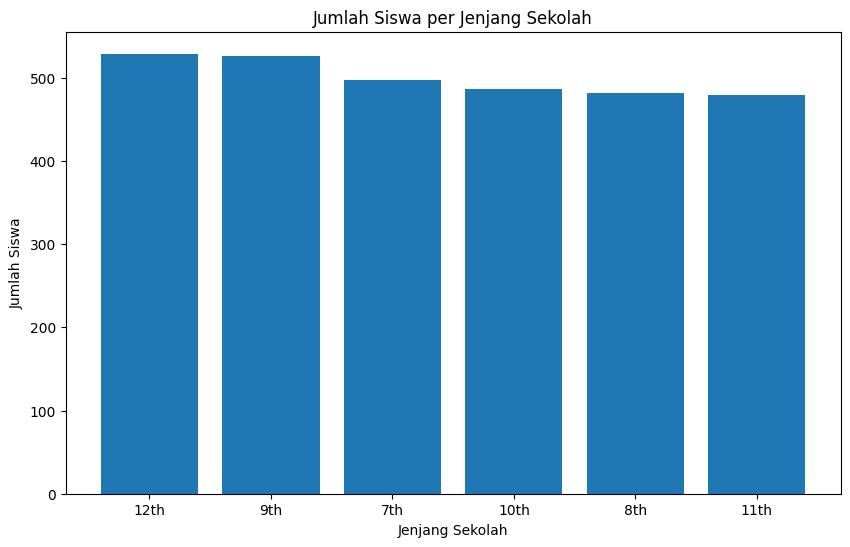

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(school_grade_counts.index, school_grade_counts.values)
plt.xlabel("Jenjang Sekolah")
plt.ylabel("Jumlah Siswa")
plt.title("Jumlah Siswa per Jenjang Sekolah")
plt.show()

In [ ]:
df_12th = df[df['School_Grade'] == '12th'].copy()
print(f"Ukuran dataset asli: {len(df)} baris")
print(f"Dataset terfilter untuk kelas 12: {len(df_12th)} baris")

Ukuran dataset asli: 3000 baris
Dataset terfilter untuk kelas 12: 529 baris


In [ ]:
print("\nStatistik Deskriptif (Hanya Kelas 12):")
df_12th.describe()


Statistik Deskriptif (Hanya Kelas 12):


,ID,Age,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,Exercise_Hours,Anxiety_Level,Depression_Level,Self_Esteem,Parental_Control,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Family_Communication,Weekend_Usage_Hours,Addiction_Level
count,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000
mean,1557.937618,15.975425,4.936862,6.459735,75.625709,5.079395,1.045936,5.540643,5.387524,5.480151,0.527410,0.982420,84.491493,12.557656,2.463894,1.520227,1.024008,5.525520,5.978072,8.829301
std,876.293288,1.960153,1.932767,1.483848,14.561253,3.143254,0.751102,2.974442,2.884637,2.900510,0.499721,0.493723,37.350870,4.554071,1.006965,0.971520,0.632703,2.837087,1.977164,1.681785
min,4.000000,13.000000,0.000000,3.000000,50.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,20.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.100000
25%,819.000000,14.000000,3.800000,5.400000,62.000000,3.000000,0.500000,3.000000,3.000000,3.000000,0.000000,0.600000,53.000000,9.000000,1.800000,0.800000,0.600000,3.000000,4.700000,7.900000
50%,1600.000000,16.000000,4.900000,6.500000,77.000000,5.000000,1.000000,6.000000,5.000000,5.000000,1.000000,1.000000,84.000000,12.000000,2.400000,1.500000,1.000000,6.000000,6.000000,10.000000
75%,2356.000000,18.000000,6.200000,7.500000,87.000000,8.000000,1.500000,8.000000,8.000000,8.000000,1.000000,1.300000,117.000000,17.000000,3.200000,2.200000,1.500000,8.000000,7.300000,10.000000
max,2996.000000,19.000000,10.300000,10.000000,100.000000,10.000000,3.600000,10.000000,10.000000,10.000000,1.000000,2.400000,150.000000,20.000000,5.000000,4.000000,3.000000,10.000000,12.400000,10.000000


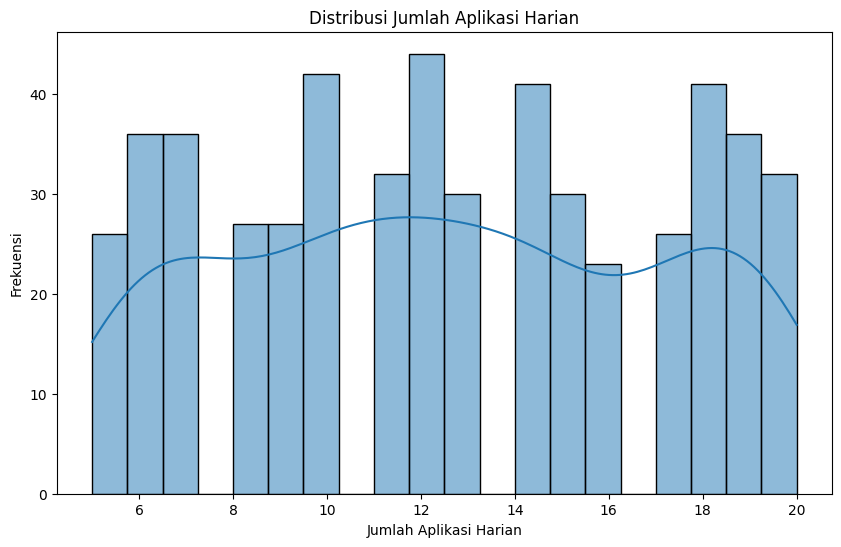

In [ ]:
# Visualisasi distribusi jumlah aplikasi harian
plt.figure(figsize=(10, 6))
sns.histplot(df_12th['Apps_Used_Daily'], bins=20, kde=True)
plt.xlabel('Jumlah Aplikasi Harian')
plt.ylabel('Frekuensi')
plt.title('Distribusi Jumlah Aplikasi Harian')
plt.show()

In [ ]:
df_12th['App_Usage_Category'] = pd.qcut(df_12th['Apps_Used_Daily'], q=4, labels=['Minimal User', 'Moderate User', 'Heavy User', 'Power User'])

In [ ]:
print("\nDistribusi Siswa Berdasarkan Profil Pengguna:")
print(df_12th['App_Usage_Category'].value_counts())


Distribusi Siswa Berdasarkan Profil Pengguna:
App_Usage_Category
Minimal User     152
Heavy User       150
Moderate User    118
Power User       109
Name: count, dtype: int64


## result analysis

In [ ]:
df[["Academic_Performance", "Apps_Used_Daily"]].corr()

,Academic_Performance,Apps_Used_Daily
Academic_Performance,1.000000,-0.026136
Apps_Used_Daily,-0.026136,1.000000


## Prediksi dengan IBM Granite

In [ ]:
performance_by_profile = df_12th.groupby('App_Usage_Category', observed=False)['Academic_Performance'].agg(['count', 'mean', 'median', 'std']).reindex(['Minimal User', 'Moderate User', 'Heavy User', 'Power User'])
summary_data_string = performance_by_profile.reset_index().to_markdown(index=False)
print(summary_data_string)

| App_Usage_Category   |   count |    mean |   median |     std |
|:---------------------|--------:|--------:|---------:|--------:|
| Minimal User         |     152 | 76.3618 |     78.5 | 14.4257 |
| Moderate User        |     118 | 75.1017 |     76   | 14.2357 |
| Heavy User           |     150 | 76.6067 |     79   | 14.7293 |
| Power User           |     109 | 73.8165 |     72   | 14.8687 |


In [ ]:
def create_prediction_prompt_from_profile(profile, summary_data):
    prompt = f"""
    Anda adalah seorang analis data ahli. Anda telah menganalisis data tentang penggunaan ponsel dan kinerja akademik siswa.
    Berikut adalah ringkasan data yang Anda temukan:
    {summary_data}

    Berdasarkan data di atas, seorang siswa diklasifikasikan sebagai '{profile}'.

    Tugas Anda:
    1. Prediksi rentang skor kinerja akademik yang paling mungkin untuk siswa ini.
    2. Berikan alasan (reasoning) singkat untuk prediksi Anda, berdasarkan data ringkasan yang diberikan.

    Format output Anda dalam JSON yang valid dengan kunci "predicted_score_range" dan "reasoning".
    """
    return prompt

In [ ]:
target_profile = "Moderate User"
prediction_prompt_1 = create_prediction_prompt_from_profile(target_profile, summary_data_string)

print(f"--- Meminta Prediksi untuk Profil: {target_profile} ---")
for event in replicate.stream(
    "ibm-granite/granite-3.3-8b-instruct",
    input={
        "prompt": prediction_prompt_1,
        "max_tokens": 150,
        "temperature": 0.1,
        "repetition_penalty": 1.2,
    },
):
    print(str(event), end="")

--- Meminta Prediksi untuk Profil: Moderate User ---
{
  "predicted_score_range": "74 - 78",
  "reasoning": "Siswa diklasifikasikan sebagai 'Moderate User' dengan rata-rata skor kinerja akademik 75.1017, median 76, dan standar deviasi 14.2357. Kategori ini memiliki nilai rata-rata dan median yang paling dekat dengan kategori 'Heavy User' (rata-rata 76.6067, median 79), menunjukkan prestasi akademik yang sama dengan kategori tersebut.

In [ ]:
def create_prediction_prompt_from_score(score, summary_data):
    prompt = f"""
    Anda adalah seorang analis data ahli. Anda telah menganalisis data tentang penggunaan ponsel dan kinerja akademik siswa.
    Berikut adalah ringkasan data yang Anda temukan:
    {summary_data}

    Seorang siswa mendapatkan skor kinerja akademik {score}.

    Tugas Anda:
    1. Prediksi profil pengguna ('Usage_Profile') yang paling mungkin untuk siswa ini.
    2. Berikan alasan (reasoning) singkat untuk prediksi Anda, berdasarkan data ringkasan yang diberikan.

    Format output Anda dalam JSON yang valid dengan kunci "predicted_profile" dan "reasoning".
    """
    return prompt

target_score = 80
prediction_prompt_2 = create_prediction_prompt_from_score(target_score, summary_data_string)

print(f"\n--- Meminta Prediksi untuk Skor Akademik: {target_score} ---")
for event in replicate.stream(
    "ibm-granite/granite-3.3-8b-instruct",
    input={
        "prompt": prediction_prompt_2,
        "max_tokens": 150,
        "temperature": 0.1,
        "repetition_penalty": 1.2,
    },
):
    print(str(event), end="")


--- Meminta Prediksi untuk Skor Akademik: 80 ---
{
  "predicted_profile": "Moderate User",
  "reasoning": "The student's academic performance score of 80 suggests a moderate level of academic achievement. Looking at the provided data summary, the 'Moderate User' category has a mean score of 75.1017 and a median of 76, which is closest to the student's performance score of 80. Although the 'Heavy User' category has a mean slightly above 75.1017, its median is 79, indicating a slightly higher usage concentration at the upper end, which might not align perfectly with an average score of 80. The 'Power User' category

## Below is some error face
---

> i use the new syntax stream cause the invoke one always cause below error (https://replicate.com/ibm-granite/granite-3.3-8b-instruct?input=python)

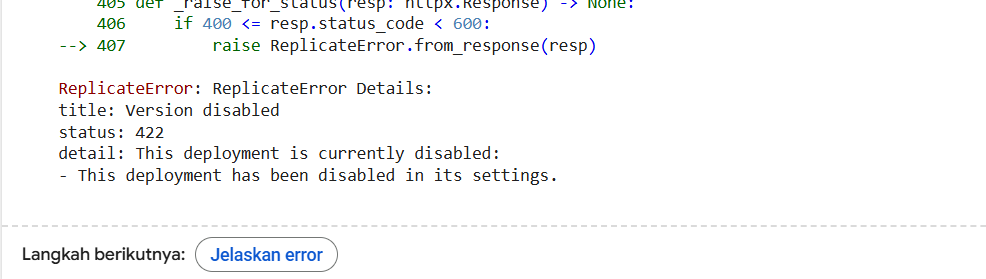